# Bragg reflection


In [ ]:
import meep as mp
import numpy as np
import matplotlib.pyplot as plt

resolution = 50
period = 1.0
num_periods = 10
d_high = 0.5
eps_high = 12
geometry_height = 3.0  
frequency = 1e12
observe_range = 0.1

cell_size = mp.Vector3(2*num_periods*period + 10, geometry_height, 0)

# =====================================
# 定义周期性矩形块（Bragg 光栅）
geometry = []
for i in range(num_periods):
    geometry.append(mp.Block(
        size=mp.Vector3(d_high, geometry_height, mp.inf),
        center=mp.Vector3(-num_periods*period + i*2*period + d_high/2),
        material=mp.Medium(epsilon=eps_high)
    ))

# =====================================
# 定义光源
sources = [mp.Source(mp.GaussianSource(frequency=frequency, fwidth=0.2),
                     component=mp.Ez,
                     center=mp.Vector3(-cell_size.x/2 + 2),
                     size=mp.Vector3(0, geometry_height))]

# =====================================
# 监测面
refl_fr = mp.FluxRegion(center=mp.Vector3(-cell_size.x/2 + 1),size=mp.Vector3(0, geometry_height))
tran_fr = mp.FluxRegion(center=mp.Vector3(cell_size.x/2 - 1),size=mp.Vector3(0, geometry_height))

# =====================================
# 先仿真空结构，记录 incident
sim = mp.Simulation(cell_size=cell_size,
                    boundary_layers=[mp.PML(0.1)],
                    geometry=[],
                    sources=sources,
                    resolution=resolution,
                    dimensions=2)

incident_flux = sim.add_flux((1-observe_range)*frequency, (1+observe_range)*frequency, 400, refl_fr)
sim.plot2D()
sim.run(until=200)
incident_data = mp.get_fluxes(incident_flux)

# =====================================
# 再仿真实际 Bragg 结构
sim.reset_meep()
sim = mp.Simulation(cell_size=cell_size,
                    boundary_layers=[mp.PML(0.1)],
                    geometry=geometry,
                    sources=sources,
                    resolution=resolution,
                    dimensions=2)

refl_flux = sim.add_flux((1-observe_range)*frequency, (1+observe_range)*frequency, 400, refl_fr)
tran_flux = sim.add_flux((1-observe_range)*frequency, (1+observe_range)*frequency, 400, tran_fr)

sim.plot2D()
sim.run(until=200)

refl_data = mp.get_fluxes(refl_flux)
tran_data = mp.get_fluxes(tran_flux)

# =====================================
# 画反射透射谱
freqs = np.linspace((1-observe_range)*frequency, (1+observe_range)*frequency, 400)
R = -np.array(refl_data) / np.array(incident_data)
T = np.array(tran_data) / np.array(incident_data)

plt.figure()
plt.plot(freqs, R, label='Reflectivity')
plt.plot(freqs, T, label='Transmittivity')
plt.xlabel('Frequency (a.u.)')
plt.ylabel('Ratio')
plt.legend()
plt.grid(True)
plt.show()


-----------
Initializing structure...
time for choose_chunkdivision = 0.01684 s
Working in 2D dimensions.
Computational cell is 2744 x 0.01 x 0 with resolution 100
     block, center = (3.43,0,0)
          size (6.86,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (13.1769,13.1769,13.1769)
     block, center = (17.15,0,0)
          size (6.86,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (13.1769,13.1769,13.1769)
     block, center = (30.87,0,0)
          size (6.86,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (13.1769,13.1769,13.1769)
     block, center = (44.59,0,0)
          size (6.86,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (13.1769,13.1769,13.1769)
     block, center = (58.31,0,0)
          size (6.86,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,

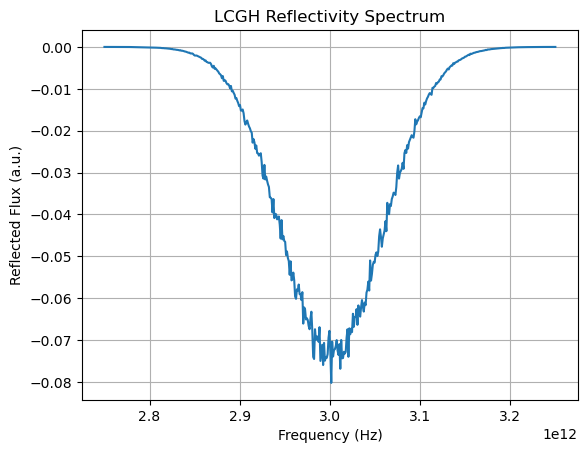

In [ ]:
import meep as mp
import numpy as np
import matplotlib.pyplot as plt

# ==== 基本参数 ====
resolution = 50  # 1 μm = 100 pts
n_eff = 3.68
dn = 0.1
n1 = n_eff - dn / 2
n2 = n_eff + dn / 2
N = 200
K = 13.72  # um
L = N * K  # um
fcen = 3.0  # THz, 中心频率
df = 0.5   # THz, 带宽
frequencies = np.linspace(fcen - df/2, fcen + df/2, 500)

# ==== 构建空间 ====
cell = mp.Vector3(L, 0, 0)

# ==== 定义光栅结构 ====
geometry = []
np.random.seed(0)
for i in range(N):
    start = i * K
    end = start + K / 2
    eps = n1 if np.random.rand() > 0.5 else n2
    geometry.append(mp.Block(
        size=mp.Vector3(K / 2, mp.inf, mp.inf),
        center=mp.Vector3(start + K / 4),
        material=mp.Medium(index=eps)
    ))

# ==== PML & source ====
pml_layers = [mp.PML(1.0)]
sources = [mp.Source(mp.GaussianSource(frequency=fcen, fwidth=df),
                     component=mp.Ez,
                     center=mp.Vector3(2),
                     size=mp.Vector3(0))]

# ==== 仿真 ====
sim = mp.Simulation(cell_size=cell,
                    boundary_layers=pml_layers,
                    geometry=geometry,
                    sources=sources,
                    resolution=resolution,
                    default_material=mp.Medium(index=n_eff))

# 监测反射光
refl_fr = mp.FluxRegion(center=mp.Vector3(1), size=mp.Vector3(0))
refl = sim.add_flux(fcen, df, 500, refl_fr)

# 运行
sim.run(until=1000)

# 记录反射率
flux_freqs = mp.get_flux_freqs(refl)
refl_data = mp.get_fluxes(refl)

# ==== 画图 ====
plt.plot(np.array(flux_freqs)*1e12, refl_data)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Reflected Flux (a.u.)")
plt.title("LCGH Reflectivity Spectrum")
plt.grid(True)
plt.show()
